### Imports 

In [1]:
from sagemaker.tensorflow import TensorFlow
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
import tensorflow as tf
import numpy as np
import sagemaker
import boto3
import os

In [2]:
print(f'Using TensorFlow version: {tf.__version__}')
print(f'Using SageMaker version: {sagemaker.__version__}')

Using TensorFlow version: 2.3.0
Using SageMaker version: 2.16.1


#### Seed for Reproducibility

In [3]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Essentials

In [4]:
role = get_execution_role()
session = boto3.Session()
sagemaker_session = sagemaker.Session()

s3 = session.resource('s3')
TF_FRAMEWORK_VERSION = '2.3.0'

BUCKET = 'cv-examples-892313895307' # USE YOUR ACCOUNT ID OR INITIALS AS SUFFIX
PREFIX = 'cifar-clf'

### Create Train Script

In [5]:
%%file cifar_train.py
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
import tensorflow as tf
import pandas as pd
import numpy as np
import argparse
import os


# Set Log Level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Seed for Reproducability 
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)


def parse_args():
    parser = argparse.ArgumentParser() 
    # hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--data', type=str, default=os.environ.get('SM_CHANNEL_DATA'))
    parser.add_argument('--output', type=str, default=os.environ.get('SM_CHANNEL_OUTPUT'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--val', type=str, default=os.environ.get('SM_CHANNEL_VAL'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    return parser.parse_known_args()


def get_train_data(train_dir):
    X_train = np.load(os.path.join(train_dir, 'X_train.npy'))
    y_train = np.load(os.path.join(train_dir, 'y_train.npy'))
    print(f'X_train: {X_train.shape} | y_train: {y_train.shape}')
    return X_train, y_train


def get_validation_data(val_dir):
    X_validation = np.load(os.path.join(val_dir, 'X_validation.npy'))
    y_validation = np.load(os.path.join(val_dir, 'y_validation.npy'))
    print(f'X_validation: {X_validation.shape} | y_validation:  {y_validation.shape}')
    return X_validation, y_validation


def get_test_data(test_dir):
    X_test = np.load(os.path.join(test_dir, 'X_test.npy'))
    y_test = np.load(os.path.join(test_dir, 'y_test.npy'))
    print(f'X_test: {X_test.shape} | y_test:  {y_test.shape}')
    return X_test, y_test


if __name__ == '__main__':
    print(f'Using TensorFlow version: {tf.__version__}')
    DEVICE = '/cpu:0'
    args, _ = parse_args()
    epochs = args.epochs
    # Load Data
    X_train, y_train = get_train_data(args.train)
    X_validation, y_validation = get_validation_data(args.val)
    X_test, y_test = get_test_data(args.test)
    
    with tf.device(DEVICE):
        # Data Augmentation
        TRAIN_BATCH_SIZE = 32
        data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
        train_iterator = data_generator.flow(X_train, y_train, batch_size=TRAIN_BATCH_SIZE)
        # Define Model Architecture
        model = Sequential()
        # CONVOLUTIONAL LAYER 1
        model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))

        # CONVOLUTIONAL LAYER 1
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))

        # CONVOLUTIONAL LAYER 3
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.3))

        # FULLY CONNECTED LAYER 
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(10, activation='softmax'))
        model.summary()
        # Compile Model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Train Model
        BATCH_SIZE = 32
        STEPS_PER_EPOCH = int(X_train.shape[0]/TRAIN_BATCH_SIZE)
        
        model.fit(train_iterator, 
                  steps_per_epoch=STEPS_PER_EPOCH, 
                  batch_size=BATCH_SIZE, 
                  epochs=epochs, 
                  validation_data=(X_validation, y_validation), 
                  callbacks=[], 
                  verbose=2, 
                  shuffle=True)
        # Evaluate on Test Set
        result = model.evaluate(X_test, y_test, verbose=1)
        print(f'Test Accuracy: {result[1]}')
        # Save Model
        model.save(f'{args.model_dir}/1')

Overwriting cifar_train.py


### Test Local Mode

In [ ]:
hyperparameters = {'epochs': 1}
estimator = TensorFlow(entry_point='cifar_train.py',
                       model_dir='/opt/ml/model/1/', # Note: this will a s3 path for real run
                       instance_type='local',
                       instance_count=1,
                       hyperparameters=hyperparameters,
                       role=role,
                       framework_version=TF_FRAMEWORK_VERSION, 
                       py_version='py37',
                       script_mode=True)

In [ ]:
estimator.fit({'train': 'file://./DATA/CIFAR_10/train', 
               'val': 'file://./DATA/CIFAR_10/validation', 
               'test': 'file://./DATA/CIFAR_10/test'})

### Copy Local Train, Validation & Test Data to S3

In [6]:
!aws s3 cp ./DATA/CIFAR_10/train s3://{BUCKET}/{PREFIX}/train --recursive

upload: DATA/CIFAR_10/train/y_train.npy to s3://cv-examples-892313895307/cifar-clf/train/y_train.npy
upload: DATA/CIFAR_10/train/X_train.npy to s3://cv-examples-892313895307/cifar-clf/train/X_train.npy


In [7]:
!aws s3 cp ./DATA/CIFAR_10/validation s3://{BUCKET}/{PREFIX}/validation --recursive

upload: DATA/CIFAR_10/validation/y_validation.npy to s3://cv-examples-892313895307/cifar-clf/validation/y_validation.npy
upload: DATA/CIFAR_10/validation/X_validation.npy to s3://cv-examples-892313895307/cifar-clf/validation/X_validation.npy


In [8]:
!aws s3 cp ./DATA/CIFAR_10/test s3://{BUCKET}/{PREFIX}/test --recursive

upload: DATA/CIFAR_10/test/y_test.npy to s3://cv-examples-892313895307/cifar-clf/test/y_test.npy
upload: DATA/CIFAR_10/test/X_test.npy to s3://cv-examples-892313895307/cifar-clf/test/X_test.npy


In [9]:
train_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/train', 
                            distribution='FullyReplicated', 
                            content_type='npy')

validation_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/validation', 
                                 distribution='FullyReplicated', 
                                 content_type='npy')

test_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/test', 
                                 distribution='FullyReplicated', 
                                 content_type='npy')

In [10]:
inputs = {'train': train_input, 'val': validation_input, 'test': test_input}

### SageMaker Training

In [ ]:
model_name = 'cifar-model-1'
hyperparameters = {'epochs': 30}
estimator_parameters = {'entry_point':'cifar_train.py',
                        'instance_type': 'ml.c4.8xlarge',
                        'instance_count': 1,
                        'model_dir': f'/opt/ml/model',
                        'role': role,
                        'hyperparameters': hyperparameters,
                        'output_path': f's3://{BUCKET}/{PREFIX}/out',
                        'base_job_name': f'cv-{model_name}',
                        'framework_version': TF_FRAMEWORK_VERSION,
                        'py_version': 'py37',
                        'script_mode': True}

estimator = TensorFlow(**estimator_parameters)

estimator.fit(inputs)

In [12]:
model_location = estimator.model_data
model_location

's3://cv-examples-892313895307/cifar-clf/out/cv-cifar-model-1-2020-11-27-01-06-52-714/output/model.tar.gz'

In [13]:
output_1 = f's3://{BUCKET}/{PREFIX}/model/model-1.tar.gz'

In [14]:
!aws s3 cp {model_location} {output_1} 

copy: s3://cv-examples-892313895307/cifar-clf/out/cv-cifar-model-1-2020-11-27-01-06-52-714/output/model.tar.gz to s3://cv-examples-892313895307/cifar-clf/model/model-1.tar.gz


### Deploy Model

In [27]:
from sagemaker.tensorflow import TensorFlowModel
from datetime import datetime
import time

In [28]:
current_time = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
current_time

'2020-11-27-01-38-43'

In [29]:
model = TensorFlowModel(model_data=output_1, 
                        role=role,  
                        name=f'cv-cifar-model-{current_time}', 
                        sagemaker_session=sagemaker_session, 
                        framework_version=TF_FRAMEWORK_VERSION)

In [30]:
predictor = model.deploy(initial_instance_count=1, 
                         instance_type='ml.m5.large', 
                         endpoint_name=f'cv-cifar-model-{current_time}')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

### Real Time Inference - Test Deployed Endpoint

In [96]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from IPython.display import Image

In [97]:
CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

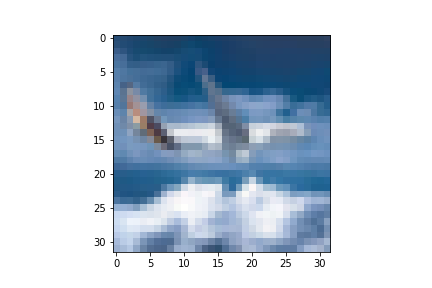

In [98]:
Image('./DATA/CIFAR_10/raw_images/airplane.png')

In [99]:
img = load_img('./DATA/CIFAR_10/raw_images/airplane.png', target_size=(32, 32))
data = img_to_array(img)
data = data.astype('float32')
data = data / 255.0
data = data.reshape(1, 32, 32, 3)

In [100]:
y_pred = predictor.predict(data)

In [101]:
predicted_label = CIFAR10_LABELS[np.argmax(y_pred)]
print(f'Predicted Label: [{predicted_label}]')

Predicted Label: [airplane]
